### 2. Library Setup

In [1]:
# Unified list of imports for a Jupyter Notebook

# Standard library imports
import os
import itertools
import time
import math
import pickle

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import average_precision_score as pr_auc


### 3. Utilities

In [2]:
def save_pkl(path, obj):
    with open(path, 'wb') as f:  # Changed 'w' to 'wb' for binary mode
        pickle.dump(obj, f)      # Changed cPickle to pickle
        print(f" [*] save {path}")

def load_pkl(path):
    with open(path, 'rb') as f:  # Changed to 'rb' for binary mode
        obj = pickle.load(f)     # Changed cPickle to pickle
        print(f" [*] load {path}")
        return obj

def save_npy(path, obj):
    np.save(path, obj)
    print(f" [*] save {path}")  # Using f-string instead of % formatting

def load_npy(path):
    obj = np.load(path, allow_pickle=True)  # Added allow_pickle=True for compatibility
    print(f" [*] load {path}")  # Using f-string
    return obj


### 4. Configuration

In [3]:
class Config:
    """feel free to play with these hyperparameters during training"""
    dataset = "resource"  # change this to the right data name
    data_path = "../%s" % dataset
    checkpoint_dir = "checkpoint"
    decay_rate = 0.95
    decay_step = 1000
    n_topics = 50
    learning_rate = 0.00002
    vocab_size = 490
    n_stops = 12
    lda_vocab_size = vocab_size - n_stops
    n_hidden = 200
    n_layers = 2
    projector_embed_dim = 100
    generator_embed_dim = n_hidden
    dropout = 1.0
    max_grad_norm = 1.0 #for gradient clipping
    total_epoch = 5
    init_scale = 0.075
    threshold = 0.5 #probability cut-off for predicting label to be 1
    forward_only = False #indicates whether we are in testing or training mode

    log_dir = '../logs'


### 5. Pre-Process Raw Data

Builds a vocabulary, converts patient records into sequential diagnosis data, labels them, and splits into train/validate/test.

In [4]:
input_file = '../resource/S1_Data.txt'
vocab_file = '../resource/vocab.txt'
stop_file = '../resource/stop.txt'
vocab_pkl = '../resource/vocab.pkl'

rare_word = 100
stop_word = 1e4
unknown = 1


def dump_vocab():
    df = pd.read_csv(input_file, sep='\t', header=0)
    print(df[0:3])

    # .to_frame(): indexed by the groups, with a custom name
    # .reset_index(): set the groups to be columns again
    hist = df.groupby('DX_GROUP_DESCRIPTION').size().to_frame('SIZE').reset_index()
    print(hist[0:3])

    # show some stats
    hist_sort = hist.sort_values(by='SIZE', ascending=False)
    print(hist_sort[0:3])
    count = hist.groupby('SIZE').size().to_frame('COUNT').reset_index()
    print(count)

    # filter
    hist = hist[hist['SIZE'] > rare_word]
    print(hist)

    # dump
    vocab = hist.sort_values(by='SIZE').reset_index()['DX_GROUP_DESCRIPTION']
    print(len(vocab))
    vocab.index += 2  # reserve 1 to unk
    vocab.to_csv(vocab_file, sep='\t', header=False, index=True)

    # stop word
    hist[hist['SIZE'] > stop_word].reset_index()['DX_GROUP_DESCRIPTION']\
        .to_csv(stop_file, sep='\t', header=False, index=False)


def load_vocab():
    word_to_index = {}
    with open(vocab_file, mode='r') as f:
        line = f.readline()
        while line != '':
            tokens = line.strip().split('\t')
            word_to_index[tokens[1]] = int(tokens[0]) - 1
            line = f.readline()
    print(f'dict size: {len(word_to_index)}')
    save_pkl(vocab_pkl, {v: k for k, v in word_to_index.items()})
    return word_to_index


def convert_format(word_to_index, events):
    # order by PID, DAY_ID
    with open(input_file, mode='r') as f:
        # header
        header = f.readline().strip().split('\t')
        print(header)
        pos = {}
        for key, value in enumerate(header):
            pos[value] = key
        print(pos)

        docs = []
        doc = []
        sent = []
        labels = []
        label = []

        # init
        line = f.readline()
        tokens = line.strip().split('\t')
        pid = tokens[pos['PID']]
        day_id = tokens[pos['DAY_ID']]
        label.append(tag(events, pid, day_id))

        while line != '':
            tokens = line.strip().split('\t')
            c_pid = tokens[pos['PID']]
            c_day_id = tokens[pos['DAY_ID']]

            # closure
            if c_pid != pid:
                doc.append(sent)
                docs.append(doc)
                sent = []
                doc = []
                pid = c_pid
                day_id = c_day_id
                labels.append(label)
                label = [tag(events, pid, day_id)]
            else:
                if c_day_id != day_id:
                    doc.append(sent)
                    sent = []
                    day_id = c_day_id
                    label.append(tag(events, pid, day_id))

            word = tokens[pos['DX_GROUP_DESCRIPTION']]
            try:
                sent.append(word_to_index[word])
            except KeyError:
                sent.append(unknown)

            line = f.readline()

        # closure
        doc.append(sent)
        docs.append(doc)
        labels.append(label)

    return docs, labels


def split_data(docs, labels):

    save_pkl('../resource/X_train.pkl', docs[:2000])
    save_pkl('../resource/Y_train.pkl', labels[:2000])
    save_pkl('../resource/X_valid.pkl', docs[2000:2500])
    save_pkl('../resource/Y_valid.pkl', labels[2000:2500])
    save_pkl('../resource/X_test.pkl', docs[2500:])
    save_pkl('../resource/Y_test.pkl', labels[2500:])


def extract_events():
    # extract event "INPATIENT HOSPITAL"
    target_event = 'INPATIENT HOSPITAL'

    df = pd.read_csv(input_file, sep='\t', header=0)
    events = df[df['SERVICE_LOCATION'] == target_event]

    events = events.groupby(['PID', 'DAY_ID', 'SERVICE_LOCATION']).size().to_frame('COUNT').reset_index()\
        .sort_values(by=['PID', 'DAY_ID'], ascending=True)\
        .set_index('PID')

    return events


def tag(events, pid, day_id):
    return 1 if tag_logic(events, pid, day_id) else 0


def tag_logic(events, pid, day_id):
    try:
        patient = events.loc[int(pid)]

        # test whether have events within 30 days
        if isinstance(patient, pd.Series):
            return (int(day_id) <= patient.DAY_ID) & (patient.DAY_ID < int(day_id) + 30)

        return patient.loc[(int(day_id) <= patient.DAY_ID) & (patient.DAY_ID < int(day_id) + 30)].shape[0] > 0
    except KeyError:
        # the label is not in the [index]
        return False


### 6. Patient Data Reader

Loads and processes patient data.

In [5]:
max_visit_size = 300


class PatientReader(object):
    def __init__(self, config):
        self.data_path = data_path = config.data_path

        self.vocab_path = vocab_path = os.path.join(data_path, "vocab.pkl")

        # use train data to build vocabulary
        if os.path.exists(vocab_path):
            self._load()
        else:
            pass

        self.vocab_size = config.vocab_size
        self.n_train_patients = math.ceil(len(self.X_train_data))
        self.n_valid_patients = math.ceil(len(self.X_valid_data))
        self.n_test_patients = math.ceil(len(self.X_test_data))

        self.lda_vocab_size = config.lda_vocab_size
        self.n_stops = config.n_stops

        self.idx2word = {v: k for k, v in self.vocab.items()} #needed to go from index to concept

        print(f"vocabulary size: {self.vocab_size}")
        print(f"number of training documents: {self.n_train_patients}")
        print(f"number of validation documents: {self.n_valid_patients}")
        print(f"number of testing documents: {self.n_test_patients}")

    def _load(self):
        self.vocab = load_pkl(self.vocab_path)

        self.X_train_data = load_pkl(self.data_path + '/' + 'X_train' + '.pkl')
        self.Y_train_data = load_pkl(self.data_path + '/' + 'Y_train' + '.pkl')

        self.X_valid_data = load_pkl(self.data_path + '/' + 'X_valid' + '.pkl')
        self.Y_valid_data = load_pkl(self.data_path + '/' + 'Y_valid' + '.pkl')

        self.X_test_data = load_pkl(self.data_path + '/' + 'X_test' + '.pkl')
        self.Y_test_data = load_pkl(self.data_path + '/' + 'Y_test' + '.pkl')

    def get_data_from_type(self, data_type):
        if data_type == "train":
            X_raw_data = self.X_train_data
            Y_raw_data = self.Y_train_data
        elif data_type == "valid":
            X_raw_data = self.X_valid_data
            Y_raw_data = self.Y_valid_data
        elif data_type == "test":
            X_raw_data = self.X_test_data
            Y_raw_data = self.Y_test_data
        else:
            raise Exception(f" [!] Unknown data type: {data_type}")

        return X_raw_data, Y_raw_data

    def get_Xc(self, data):
        """data is a patient...a sequence of visits
            so a list of lists...the outer list is of size T_patient
            the inner lists contain the concepts within each visit
        """
        patient = [concept for visit in data for concept in visit]
        patient = [x-1 for x in patient]
        counts = np.bincount(patient, minlength=self.vocab_size + 1)
        counts = counts[1:self.vocab_size + 1] #added for size 490

        stops_flag = np.array(list(np.ones([self.lda_vocab_size], dtype=np.int32)) +
                              list(np.zeros([self.n_stops], dtype=np.int32)))

        return counts * stops_flag

    def get_X(self, data):
        """
        data is a list of lists of different length
        return an array of shape CxT where
        entry Mij = ci if ci in visit j
        """
        T_patient = len(data)
        res = np.zeros([self.vocab_size, T_patient])
        for i in range(self.vocab_size):
            for j in range(T_patient):
                if (i+1) in data[j]:
                    res[i, j] = (i+1)

        return res

    def iterator(self, data_type="train"):
        """
        goes over the data and
        returns X, Xc, Y, and seq_len in a round robin
        seq_len is a vector of size C where each
        entry is T_patient
        """
        X_raw_data, Y_raw_data = self.get_data_from_type(data_type)

        x_infos = itertools.cycle(([self.get_X(X_doc[:max_visit_size]), self.get_Xc(X_doc[:max_visit_size])]
                                   for X_doc in X_raw_data if X_doc != []))
        y_infos = itertools.cycle(([Y_doc[:max_visit_size], np.array([len(Y_doc[:max_visit_size])]*self.vocab_size)]
                                   for Y_doc in Y_raw_data if Y_doc != []))

        return x_infos, y_infos


### 7. Execute Data Transformation

In [ ]:
# print(os.getcwd())
dump_vocab() # comment out if not needed
word_to_index = load_vocab()
events = extract_events()

docs, labels = convert_format(word_to_index, events)
split_data(docs, labels)

# verify loading
config = Config()
reader = PatientReader(config)
iterator = reader.iterator()
X, Xc = next(iterator[0])  # Changed .next() to next()
Y, seq_len = next(iterator[1])  # Changed .next() to next()
#printing stuff to debug
print("X is of shape CxT_patient: ", X)
print("Xc is of shape Cx1: ", Xc.shape)
print("seq_len is of shape Cx1: ", seq_len.shape)


dict size: 490
 [*] save ../resource/vocab.pkl
['PID', 'DAY_ID', 'DX_GROUP_DESCRIPTION', 'SERVICE_LOCATION', 'OP_DATE']
{'PID': 0, 'DAY_ID': 1, 'DX_GROUP_DESCRIPTION': 2, 'SERVICE_LOCATION': 3, 'OP_DATE': 4}
 [*] save ../resource/X_train.pkl
 [*] save ../resource/Y_train.pkl
 [*] save ../resource/X_valid.pkl
 [*] save ../resource/Y_valid.pkl
 [*] save ../resource/X_test.pkl
 [*] save ../resource/Y_test.pkl
 [*] load ../resource/vocab.pkl
 [*] load ../resource/X_train.pkl
 [*] load ../resource/Y_train.pkl
 [*] load ../resource/X_valid.pkl
 [*] load ../resource/Y_valid.pkl
 [*] load ../resource/X_test.pkl
 [*] load ../resource/Y_test.pkl
vocabulary size: 490
number of training documents: 2000
number of validation documents: 500
number of testing documents: 500
X is of shape CxT_patient:  [[  0.   1.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0. 489.   0. ...   0.   0.   0.]
 [  0.   0.  

### 8. Train Word Embeddings

In [ ]:
import pickle
import os

def load_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def load_vocab_mapping(vocab_path):
    """
    Reads the vocab file and creates a dictionary mapping
    the integer index to the diagnosis string.
    """
    mapping = {}
    with open(vocab_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tokens = line.split('\t')
            index = int(tokens[0]) - 1
            diagnosis = tokens[1]
            mapping[index] = diagnosis
    return mapping

def build_corpus(pkl_paths, vocab_mapping):
    """
    Given a list of paths to pickled files (each containing a list of patients,
    where each patient is a list of visits, and each visit is a list of diagnosis indices),
    create a corpus where each "sentence" corresponds to a visit with diagnosis strings.
    """
    corpus = []
    looks = []
    for pkl_path in pkl_paths:
        if not os.path.exists(pkl_path):
            print(f"File not found: {pkl_path}")
            continue
        data = load_pkl(pkl_path)
        # Each element in data is a patient record (a list of visits)
        for patient in data:
            # Each visit is a list of diagnosis indices.
            for visit in patient:
                if visit:  # ensure the visit is not empty
                    # Map each index to its corresponding diagnosis string.
                    # If an index is not found in the mapping, use a placeholder "UNK".
                    sentence = []
                    for token in visit:
                        if token in vocab_mapping:
                            sentence.append(vocab_mapping[token])
                        else:
                            looks.append("{} found in visit: {}".format(token, visit))
                    corpus.append(sentence)
    return corpus, looks


Loaded vocab mapping for 490 words.
Number of sentences in corpus: 239936
First 5 sentences:
['ANGINA PECTORIS', 'MONONEURITIS OF UPPER LIMB AND MONONEURITIS MULTIPLEX', 'SYMPTOMS INVOLVING RESPIRATORY SYSTEM AND OTHER CHEST SYMPTOMS']
['DISEASES OF THE ORAL SOFT TISSUES, EXCLUDING LESIONS SPECIFIC FOR GINGIVA AND TONGUE', 'DIABETES MELLITUS', 'ESSENTIAL HYPERTENSION', 'OTHER FORMS OF CHRONIC ISCHEMIC HEART DISEASE']
['EZETIMIBE']
['CATARACT', 'OTHER AND ILL-DEFINED CEREBROVASCULAR DISEASE', 'VISUAL DISTURBANCES']
['ESSENTIAL HYPERTENSION', 'OTHER AND UNSPECIFIED DISORDERS OF BACK', 'OTHER FORMS OF CHRONIC ISCHEMIC HEART DISEASE', 'OTHER PERSONS SEEKING CONSULTATION WITHOUT COMPLAINT OR SICKNESS']


In [ ]:
# Example usage:
vocab_path = "../resource/vocab.txt"
pkl_paths = [
    "../resource/X_train.pkl",
    "../resource/X_valid.pkl",
    "../resource/X_test.pkl"
]

# Load the vocab mapping
vocab_mapping = load_vocab_mapping(vocab_path)
print("Loaded vocab mapping for {} words.".format(len(vocab_mapping)))

# Build the corpus using the mapping
corpus, looks = build_corpus(pkl_paths, vocab_mapping)

# Print some information about the corpus
print("Number of sentences in corpus:", len(corpus))
print("First 5 sentences:")
for sent in corpus[:5]:
    print(sent)


In [8]:
from gensim.models import Word2Vec

# 2. Initialize and train the Word2Vec model
model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)
model.train(corpus, total_examples=len(corpus), epochs=10)

# 3. Save the word vectors in text format (word2vec.vector)
model.wv.save_word2vec_format("../resource/word2vec.vector", binary=False)


### 9. Initialize CONTENT Architecure

In [9]:
# CUDA setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Number of units in the hidden (recurrent) layer
N_HIDDEN = 200

# All gradients above this will be clipped
GRAD_CLIP = 100
# How often should we check the output?
EPOCH_SIZE = 100
# Number of epochs to train the net
num_epochs = 2 #changed from 6


# Define custom PyTorch modules to replace Lasagne's layers
class MaskingLayer(nn.Module):
    def __init__(self):
        super(MaskingLayer, self).__init__()

    def forward(self, x, mask):
        # Apply mask to the input tensor
        return x * mask.unsqueeze(-1)


class ThetaLayer(nn.Module):
    def __init__(self, maxlen):
        super(ThetaLayer, self).__init__()
        self.maxlen = maxlen
        self.klterm = 0
        self.theta = None

    def forward(self, mu, log_sigma):
        batch_size, n_topics = mu.size()

        # Reparameterization trick
        epsilon = torch.randn_like(mu)
        z = mu + torch.exp(0.5 * log_sigma) * epsilon

        # Apply softmax to get theta
        theta = F.softmax(z, dim=1)

        # Save theta for later use
        self.theta = theta

        # Compute KL divergence
        self.klterm = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())

        # Expand theta to match maxlen
        expanded_theta = theta.unsqueeze(1).expand(-1, self.maxlen, -1)

        return expanded_theta


class ContentModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_topics, max_length):
        super(ContentModel, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_topics = n_topics
        self.max_length = max_length

        # Embedding layer
        self.embed = nn.Linear(vocab_size, embed_size, bias=False)

        # GRU layer
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)

        # Topic model layers
        self.dense1 = nn.Linear(vocab_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, n_topics)
        self.log_sigma = nn.Linear(hidden_size, n_topics)

        # Output layers
        self.B = nn.Linear(vocab_size, n_topics, bias=False)
        self.output_dense = nn.Linear(hidden_size, 1)

        # Theta layer
        self.theta_layer = ThetaLayer(max_length)

    def forward(self, x, mask):
        batch_size, seq_len, vocab_size = x.size()

        # Embedding
        embedded = self.embed(x)

        # Apply mask to embedded
        embedded = embedded * mask.unsqueeze(-1)

        # GRU layer
        gru_out, h_n = self.gru(embedded)

        # Topic model
        h1 = F.relu(self.dense1(x))
        h2 = F.relu(self.dense2(h1))
        mu = self.mu(h2.mean(dim=1))  # Average over sequence length
        log_sigma = self.log_sigma(h2.mean(dim=1))

        # Get theta
        theta_expanded = self.theta_layer(mu, log_sigma)

        # Context vector
        B_out = self.B(x)  # [batch, seq_len, n_topics]
        context = (B_out * theta_expanded).mean(dim=-1)  # [batch, seq_len]

        # Output predictions
        dense_out = self.output_dense(gru_out).squeeze(-1)  # [batch, seq_len]
        out = dense_out + context
        out = torch.sigmoid(out)

        # Apply mask to output
        out = out * mask + 1e-6

        return out, h_n, self.theta_layer.theta


Using device: cpu


### 10. Prepare data for feed-forward

In [10]:

def prepare_data(seqs, labels, vocabsize, maxlen=None):
    """Create the matrices from the datasets.

    This pad each sequence to the same lenght: the lenght of the
    longuest sequence or maxlen.

    if maxlen is set, we will cut all sequence to this maximum
    lenght.

    This swap the axis!
    """
    # x: a list of sentences
    lengths = [len(s) for s in seqs]

    eventSeq = []

    for seq in seqs:
        t = []
        for visit in seq:
            t.extend(visit)
        eventSeq.append(t)
    eventLengths = [len(s) for s in eventSeq]

    if maxlen is not None:
        new_seqs = []
        new_lengths = []
        new_labels = []
        for l, s, la in zip(lengths, seqs, labels):
            if l < maxlen:
                new_seqs.append(s)
                new_lengths.append(l)
                new_labels.append(la)
            else:
                new_seqs.append(s[:maxlen])
                new_lengths.append(maxlen)
                new_labels.append(la[:maxlen])
        lengths = new_lengths
        seqs = new_seqs
        labels = new_labels

        if len(lengths) < 1:
            return None, None, None

    n_samples = len(seqs)
    maxlen = np.max(lengths)

    x = np.zeros((n_samples, maxlen, vocabsize)).astype('float32')
    x_mask = np.zeros((n_samples, maxlen)).astype('float32')
    y = np.ones((n_samples, maxlen)).astype('float32')
    for idx, s in enumerate(seqs):
        x_mask[idx, :lengths[idx]] = 1
        for j, sj in enumerate(s):
            for tsj in sj:
                x[idx, j, tsj - 1] = 1
    for idx, t in enumerate(labels):
        y[idx, :lengths[idx]] = t

    return x, x_mask, y, lengths, eventLengths


### 11. Train Model (+ Helper Functions)

In [11]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


def iterate_minibatches_listinputs(inputs, batchsize, shuffle=False):
    assert inputs is not None
    if shuffle:
        indices = np.arange(len(inputs[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [input[excerpt] for input in inputs]


def loadEmbeddingMatrix(wordvecFile, word_to_index, vocab_size):
    dic = {}
    for k, v in word_to_index.items():
        dic[v] = k
    #print(dic)
    with open(wordvecFile, "r") as fw:
        headline = fw.readline().strip().split()
        # headline should contain two numbers: total words and dimension
        total, dim = int(headline[0]), int(headline[1])
        # Create an embedding matrix of shape (vocab_size, dim)
        W = np.zeros((vocab_size, dim), dtype=np.float32)
        for line in fw:
            #print(line)
            tabs = line.strip().split()
            word = ""
            nums = []
            for tab in tabs:
                try:
                    nums.append(float(tab))
                except:
                    word += "{} ".format(tab)
            word = word.strip()
            vec = np.asarray(nums)
            try:
                token_value = dic[word]
            except:
                print("{} is not in dic, so could not get index".format(word))
                continue
            W[token_value - 1] = vec
    return W


In [12]:

def main(data_sets, W_embed):
    # Learning rate
    learning_rate = 0.001

    # Min/max sequence length
    MAX_LENGTH = 300

    # Get training data
    X_raw_data, Y_raw_data = data_sets.get_data_from_type("train")
    trainingAdmiSeqs, trainingMask, trainingLabels, trainingLengths, ltr = prepare_data(X_raw_data, Y_raw_data,
                                                                                        vocabsize=490,
                                                                                        maxlen=MAX_LENGTH)
    Num_Samples, MAX_LENGTH, N_VOCAB = trainingAdmiSeqs.shape

    # Get validation data
    X_valid_data, Y_valid_data = data_sets.get_data_from_type("valid")
    validAdmiSeqs, validMask, validLabels, validLengths, lval = prepare_data(X_valid_data, Y_valid_data, vocabsize=490,
                                                                             maxlen=MAX_LENGTH)

    # Get test data
    X_test_data, Y_test_data = data_sets.get_data_from_type("test")
    test_admiSeqs, test_mask, test_labels, testLengths, ltes = prepare_data(X_test_data, Y_test_data, vocabsize=490,
                                                                            maxlen=MAX_LENGTH)

    # Print statistics
    alllength = sum(trainingLengths) + sum(validLengths) + sum(testLengths)
    print(f"Total sequence length: {alllength}")
    eventNum = sum(ltr) + sum(lval) + sum(ltes)
    print(f"Total event count: {eventNum}")

    print("Building network ...")
    N_BATCH = 1
    embedsize = 100
    n_topics = 50

    # Create model
    model = ContentModel(
        vocab_size=N_VOCAB,
        embed_size=embedsize,
        hidden_size=N_HIDDEN,
        n_topics=n_topics,
        max_length=MAX_LENGTH
    ).to(device)

    # If we have pretrained embeddings, use them
    if W_embed is not None:
        with torch.no_grad():
            model.embed.weight.copy_(torch.from_numpy(W_embed.T))

    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create output directory
    os.makedirs("theta_with_rnnvec", exist_ok=True)
    os.makedirs("CONTENT_results", exist_ok= True)
    

    print("Training ...")
    try:
        for epoch in range(num_epochs):
            train_err = 0
            train_batches = 0
            start_time = time.time()
            thetas_train = []

            # Set model to training mode
            model.train()

            for batch in iterate_minibatches_listinputs([trainingAdmiSeqs, trainingLabels, trainingMask], N_BATCH, shuffle=True):
                inputs = batch

                # Convert numpy arrays to torch tensors
                x = torch.FloatTensor(inputs[0]).to(device)
                y = torch.FloatTensor(inputs[1]).to(device)
                mask = torch.FloatTensor(inputs[2]).to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs, h_n, theta = model(x, mask)

                # Compute loss
                loss = F.binary_cross_entropy(outputs.flatten(), y.flatten(), reduction='sum')
                loss += model.theta_layer.klterm

                # Backward pass and optimize
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()

                # Save statistics
                train_err += loss.item()
                train_batches += 1

                # Save theta and RNN vectors
                rnnvec_train = h_n.squeeze(0).detach().cpu().numpy()
                theta_train = theta.detach().cpu().numpy()
                rnnout_train = np.concatenate([theta_train, rnnvec_train], axis=1)
                thetas_train.append(rnnout_train.flatten())

                if (train_batches + 1) % 1000 == 0:
                    print(train_batches)

            # Save thetas
            np.save(f"theta_with_rnnvec/thetas_train{epoch}", thetas_train)

            # Print epoch statistics
            print(f"Epoch {epoch + 1} of {num_epochs} took {time.time() - start_time:.3f}s")
            print(f"  training loss:\t\t{train_err / train_batches:.6f}")

            # Evaluate on test set
            test_err = 0
            test_batches = 0
            new_testlabels = []
            pred_testlabels = []
            thetas = []

            # Set model to evaluation mode
            model.eval()

            with torch.no_grad():
                for batch in iterate_minibatches_listinputs([test_admiSeqs, test_labels, test_mask, testLengths], 1, shuffle=False):
                    inputs = batch

                    # Convert numpy arrays to torch tensors
                    x = torch.FloatTensor(inputs[0]).to(device)
                    y = torch.FloatTensor(inputs[1]).to(device)
                    mask = torch.FloatTensor(inputs[2]).to(device)
                    leng = inputs[3][0]

                    # Forward pass
                    outputs, h_n, theta = model(x, mask)

                    # Compute loss
                    loss = F.binary_cross_entropy(outputs.flatten(), y.flatten(), reduction='sum')
                    loss += model.theta_layer.klterm

                    # Save statistics
                    test_err += loss.item()
                    test_batches += 1

                    # Save predictions and labels
                    new_testlabels.extend(y.cpu().numpy().flatten()[:leng])
                    pred_testlabels.extend(outputs.cpu().numpy().flatten()[:leng])

                    # Save theta and RNN vectors
                    rnnvec = h_n.squeeze(0).cpu().numpy()
                    theta_np = theta.cpu().numpy()
                    rnnout = np.concatenate([theta_np, rnnvec], axis=1)
                    thetas.append(rnnout.flatten())

            # Compute metrics
            test_auc = roc_auc_score(new_testlabels, pred_testlabels)
            test_pr_auc = pr_auc(new_testlabels, pred_testlabels)
            test_pre_rec_f1 = precision_recall_fscore_support(
                np.array(new_testlabels),
                np.array(pred_testlabels) > 0.5,
                average='binary'
            )
            test_acc = accuracy_score(np.array(new_testlabels), np.array(pred_testlabels) > 0.5)

            np.save("CONTENT_results/testlabels_"+str(epoch), new_testlabels)
            np.save("CONTENT_results/predlabels_"+str(epoch), pred_testlabels)
            np.save(f"theta_with_rnnvec/thetas_test{epoch}", thetas)

            # Print results
            print("Final results:")
            print(f"  test loss:\t\t{test_err / test_batches:.6f}")
            print(f"  test auc:\t\t{test_auc:.6f}")
            print(f"  test pr_auc:\t\t{test_pr_auc:.6f}")
            print(f"  test accuracy:\t\t{test_acc * 100:.2f} %")
            print(
                f"  test Precision, Recall and F1:\t\t{test_pre_rec_f1[0]:.4f} %\t\t{test_pre_rec_f1[1]:.4f}\t\t{test_pre_rec_f1[2]:.4f}")

    except KeyboardInterrupt:
        pass


In [13]:
FLAGS = Config()
data_sets = PatientReader(FLAGS)
wordvecPath = os.path.join(FLAGS.data_path, "word2vec.vector")

if os.path.exists(wordvecPath):
    W_embed = loadEmbeddingMatrix(wordvecPath, vocab_mapping, 490)
else:
    print(f"Warning: Word embedding file not found at {wordvecPath}")
    W_embed = None

main(data_sets, W_embed)


vocabulary size: 490
number of training documents: 2000
number of validation documents: 500
number of testing documents: 500
POLYETHYLENE GLYCOL is not in dic, so could not get index
Total sequence length: 239887
Total event count: 685482
Building network ...
Training ...
999
1999
Epoch 1 of 2 took 163.079s
  training loss:		3080.936375
Final results:
  test loss:		3070.078199
  test auc:		0.798597
  test pr_auc:		0.635179
  test accuracy:		83.42 %
  test Precision, Recall and F1:		0.7808 %		0.3603		0.4931
999
1999
Epoch 2 of 2 took 181.026s
  training loss:		3079.621822
Final results:
  test loss:		3070.496248
  test auc:		0.800252
  test pr_auc:		0.644148
  test accuracy:		83.38 %
  test Precision, Recall and F1:		0.8334 %		0.3219		0.4644


### 12. Evaluate on Testing Data

In [ ]:

def eval(epoch):
    new_testlabels = np.load(f"CONTENT_results/testlabels_{epoch}.npy")
    pred_testlabels = np.load(f"CONTENT_results/predlabels_{epoch}.npy")
    test_auc = roc_auc_score(new_testlabels, pred_testlabels)
    test_pr_auc = pr_auc(new_testlabels, pred_testlabels)
    test_acc = accuracy_score(new_testlabels, pred_testlabels > 0.5)
    print(f'AUC: {test_auc:.4f}')
    print(f'PRAUC: {test_pr_auc:.4f}')
    print(f'ACC: {test_acc:.4f}')

    pre, rec, threshold = precision_recall_curve(new_testlabels, pred_testlabels)
    test_pre_rec_f1 = precision_recall_fscore_support(new_testlabels, pred_testlabels > 0.5, average='binary')
    print(
        f"  test Precision, Recall and F1:\t\t{test_pre_rec_f1[0]:.4f} %\t\t{test_pre_rec_f1[1]:.4f}\t\t{test_pre_rec_f1[2]:.4f}")

    import matplotlib.pyplot as plt
    plt.plot(rec, pre, label='CONTENT')
    plt.legend()
    plt.title("Precision-Recall Curves")
    plt.show()


AUC: 0.8003
PRAUC: 0.6441
ACC: 0.8338
  test Precision, Recall and F1:		0.8334 %		0.3219		0.4644


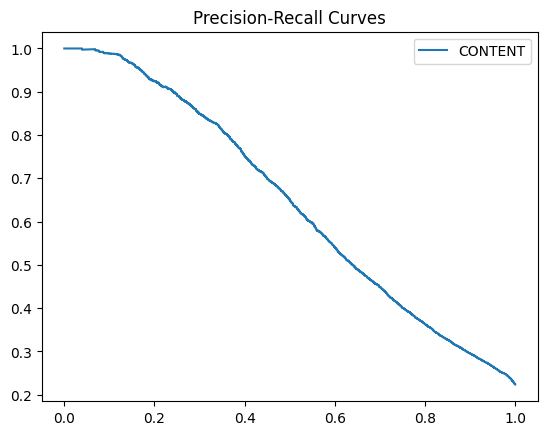

In [15]:
eval(1)


### 13. Clustering (Optional)

In [16]:

def list2dic(_list):
    output = dict()
    for i in _list:
        if i in output:
            output[i] += 1
        else:
            output[i] = 0
    return output


def outputCodes(indexs, patientList):
    HightPat = []
    for i in indexs:
        HightPat.extend(patientList[i])
    high = list2dic(HightPat)
    items = sorted(high.items(), key=lambda d: d[1], reverse=True)
    for key, value in items[:20]:
        print(key, value)


def scatter(x, colors):
    import matplotlib.patheffects as PathEffects
    import seaborn as sns
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 50))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    # We add the labels for each digit.
    txts = []
    return f, ax, sc, txts


def clustering(thetaPath, dataset):
    from sklearn.cluster import MiniBatchKMeans
    from sklearn.manifold import TSNE

    thetas = np.asarray(np.load(thetaPath))[:, 50:]
    ypred = MiniBatchKMeans(n_clusters=20).fit_predict(thetas).flatten()
    tsn = TSNE(random_state=256, n_iter=2000).fit_transform(thetas)
    scatter(tsn, ypred)
    plt.show()

    X_test_data, Y_test_data = dataset.get_data_from_type("test")
    new_X = []
    for s in X_test_data:
        ss = []
        for t in s:
            ss.extend(t)
        new_X.append(ss)

    print("\n")

    for ylabel in range(20):
        indexs = np.where(ypred == ylabel)[0]
        print("Cluster", ylabel)
        outputCodes(indexs, new_X)
        n = []
        for i in indexs:
            n.append(sum(Y_test_data[i]))
        n = np.array(n)
        aveCount = np.mean(n)
        stdev = np.std(n)
        print("Number of Examples:\t", len(indexs))
        print("Readmission AveCount:\t", aveCount)
        print("Readmission Std:\t", stdev)
        print("\n")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


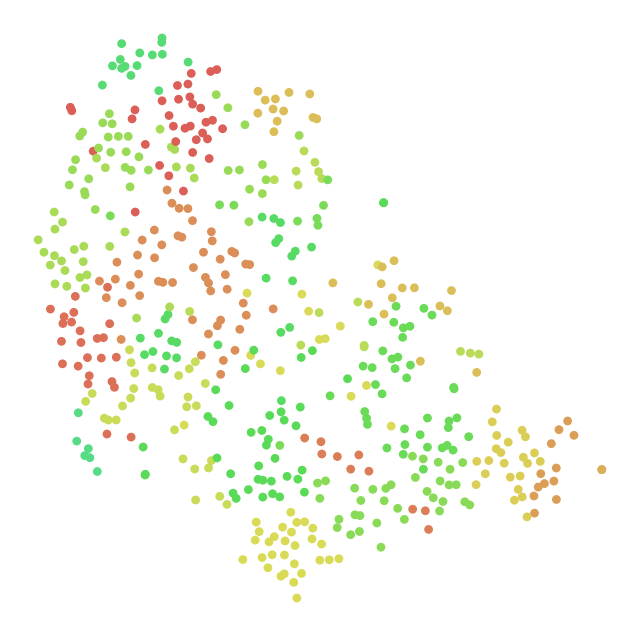



Cluster 0
489 295
488 247
490 235
486 217
487 146
481 145
475 142
1 132
484 124
474 117
485 113
480 99
449 95
483 82
482 54
420 51
397 50
438 49
472 47
478 45
Number of Examples:	 33
Readmission AveCount:	 7.757575757575758
Readmission Std:	 8.242647055811926


Cluster 1
490 219
487 150
488 146
489 126
1 99
486 94
484 88
480 61
485 60
478 55
483 54
475 46
471 44
470 43
477 39
481 38
453 35
473 35
462 30
458 29
Number of Examples:	 24
Readmission AveCount:	 5.5
Readmission Std:	 7.421814692737439


Cluster 2
487 249
490 214
489 165
483 142
488 135
1 114
447 86
477 67
486 64
475 60
480 59
371 56
479 55
485 51
373 51
482 46
478 45
339 45
431 42
227 41
Number of Examples:	 10
Readmission AveCount:	 31.6
Readmission Std:	 8.720091742636656


Cluster 3
490 489
488 443
489 409
486 278
1 201
485 190
484 176
487 176
480 159
481 122
478 115
472 103
483 101
474 92
473 85
482 85
469 83
470 79
477 74
438 66
Number of Examples:	 50
Readmission AveCount:	 9.34
Readmission Std:	 8.48200448007427


C

In [17]:
thetaPath = "theta_with_rnnvec/thetas_test0.npy"
clustering(thetaPath, data_sets)
